# Simple thick lens

This example shows how to create and analyze a simple thick lens as described in the paper 
[ZOSPy: optical ray tracing in Python through OpticStudio](https://joss.theoj.org/papers/10.21105/joss.05756). 
The code resembles the example of the paper with the addition of plotting the analysis results.

## Included functionalities

* _Sequential mode_:
  - Building a simple sequential optical system.
  - Usage of `zospy.analyses.mtf.fft_through_focus_mtf` to calculate the FFT through focus MTF.
  - Usage of `zospy.analyses.psf.huygens_psf()` to perform a Huygens PSF analysis.

## Warranty and liability

The examples are provided 'as is'. There is no warranty and rights cannot be derived from them, as is also stated in the 
general license of this repository.



This example requires to connect to OpticStudio as extension. Also make sure ZOSPy is in sequential mode before running this example.

## Import dependencies

In [1]:
from warnings import warn

import matplotlib.pyplot as plt

import zospy as zp

## Setup the connection

Initiate the connection to OpticStudio

In [2]:
zos = zp.ZOS()
oss = zos.connect("extension")

Get the primary system and make sure it is an new, empty system

In [3]:
oss.new()

## Set up the optical system
1. Alter some system settings regarding the aperture size

In [4]:
oss.SystemData.Aperture.ApertureValue = 10

2. Add the SCHOTT glass catalog if it is not already in use

In [5]:
if "SCHOTT" not in oss.SystemData.MaterialCatalogs.GetCatalogsInUse():
    oss.SystemData.MaterialCatalogs.AddCatalog("SCHOTT")

print(
    "Catalogs currently in use:",
    " ".join(oss.SystemData.MaterialCatalogs.GetCatalogsInUse()),
)

Catalogs currently in use: SCHOTT 


3. Create an input beam for viewing purposes

In [6]:
input_beam = oss.LDE.InsertNewSurfaceAt(1)  # behind the object surface
input_beam.Thickness = 10

4. Make a 10 mm thick lens with a radius of curvature of 30 mm and material type BK10

In [7]:
front_surface = oss.LDE.GetSurfaceAt(2)
front_surface.Radius = 30
front_surface.Thickness = 10
front_surface.SemiDiameter = 15
front_surface.Material = "BK10"

back_surface = oss.LDE.InsertNewSurfaceAt(3)
back_surface.Radius = -30
back_surface.Thickness = 29
back_surface.SemiDiameter = 15

5. Specify the detector surface

In [8]:
image_surface = oss.LDE.GetSurfaceAt(4)
image_surface.SemiDiameter = 5

## Render the model

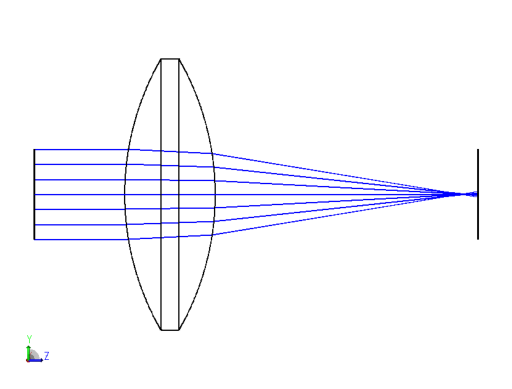

In [9]:
draw3d = zp.analyses.systemviewers.Viewer3D(
    surface_line_thickness="Thick",
    rays_line_thickness="Thick",
    number_of_rays=7,
    hide_x_bars=True,
).run(oss, oncomplete="Release")

if zos.version < (24, 1, 0):
    warn(
        "Exporting the 3D viewer data is not available for this version of OpticStudio."
    )
else:
    plt.imshow(draw3d.data)
    plt.axis("off")

## Analyze the model and show the results

1. Calculte the *FFT through focus MTF* and plot it

In [10]:
mtf = zp.analyses.mtf.FFTThroughFocusMTF(
    sampling="512x512", delta_focus=2.5, frequency=3, number_of_steps=51
).run(oss, oncomplete="Sustain")

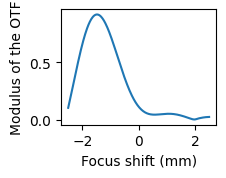

In [11]:
fig = plt.figure(figsize=(2, 1.5))
ax = fig.add_subplot(111)
ax.plot(mtf.data.index, mtf.data[("Field: 0,0000 (deg)", "Tangential")])
ax.set_xlabel("Focus shift (mm)")
_ = ax.set_ylabel("Modulus of the OTF")

In [12]:
mtf.data

Description  Field: 0,0000 (deg)          
SeriesLabels          Tangential  Sagittal
Focal Shift                               
-2.500000               0.103930  0.103930
-2.483278               0.122375  0.122375
-2.466555               0.140851  0.140851
-2.449833               0.159388  0.159388
-2.433110               0.178017  0.178017
...                          ...       ...
 2.433110               0.023551  0.023551
 2.449833               0.023792  0.023792
 2.466555               0.024007  0.024007
 2.483278               0.024204  0.024204
 2.500000               0.024392  0.024392

[300 rows x 2 columns]

2. Calculate the Huygens PSF and plot it

In [13]:
huygens_psf = zp.analyses.psf.HuygensPSF(
    pupil_sampling="512x512", image_sampling="512x512", normalize=True
).run(oss)

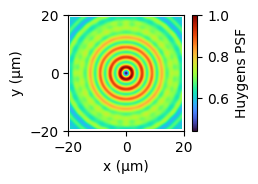

In [14]:
fig = plt.figure(figsize=(2, 1.5))
ax = fig.add_subplot(111)
im = ax.imshow(
    huygens_psf.data,
    cmap="turbo",
    extent=[
        huygens_psf.data.columns.values.min(),
        huygens_psf.data.columns.values.max(),
        huygens_psf.data.index.values.min(),
        huygens_psf.data.index.values.max(),
    ],
)
plt.colorbar(im, label="Huygens PSF")
ax.set_xlabel("x (μm)")
ax.set_ylabel("y (μm)")
ax.set_xticks([-20, 0, 20])
_ = ax.set_yticks([-20, 0, 20])